In [1]:
import os
import numpy as np
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping

2024-04-26 18:42:42.803113: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
cancer_folder = '/raid/mpsych/OMAMA/DATA/data/2d_512_cancer'
noncancer_folder = '/raid/mpsych/OMAMA/DATA/data/2d_512_Noncancer'

cancer_files = [os.path.join(cancer_folder, f) for f in os.listdir(cancer_folder) if f.endswith('.npz')]
noncancer_files = [os.path.join(noncancer_folder, f) for f in os.listdir(noncancer_folder) if f.endswith('.npz')]
noncancer_files = noncancer_files[:7351]

In [3]:
len(cancer_files)

7351

In [4]:
len(noncancer_files)

7351

In [5]:
def load_data(file_paths):
    data = []
    for file_path in file_paths:
        with np.load(file_path) as data_file:
            data.append(data_file['data'])
    return np.array(data)


In [6]:
def load_data(file_paths):
    data = []
    for file_path in file_paths:
        with np.load(file_path) as data_file:
            # Load image data
            img_data = data_file['data']
            # Normalize image data to the range [0, 1]
            max_val = np.max(img_data)
            if max_val > 0:
                img_data = img_data / max_val
            data.append(img_data)
    return np.array(data)

In [28]:
def load_data(file_paths):
    data = []
    for file_path in file_paths:
        with np.load(file_path) as data_file:
            # Load image data
            img_data = data_file['data']
            # Z-score normalization
            mean = np.mean(img_data)
            std = np.std(img_data)
            img_data = (img_data - mean) / std
            data.append(img_data)
    return np.array(data)

In [31]:
cancer_data = load_data(cancer_files)
noncancer_data = load_data(noncancer_files)

In [32]:
# cancer_data = cancer_data / np.max(cancer_data)
# noncancer_data = noncancer_data / np.max(noncancer_data)

# Assign labels (1 for cancer, 0 for non-cancer)
cancer_labels = np.ones(len(cancer_data))
noncancer_labels = np.zeros(len(noncancer_data))

# Concatenate data and labels
X = np.concatenate((cancer_data, noncancer_data))
y = np.concatenate((cancer_labels, noncancer_labels))
X = np.expand_dims(X, axis=-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
len(X_train)

11761

In [10]:
len(X_test)

2941

In [11]:
len(y_train)

11761

In [12]:
first_image = X_train[100]
first_label = y_train[100]

Populating the interactive namespace from numpy and matplotlib


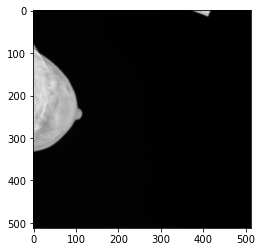

In [13]:
%pylab inline
imshow(first_image, cmap='gray')

In [14]:
first_label

1.0

In [15]:
first_image.shape

(512, 512, 1)

In [33]:
first_image.max()

1.0

In [34]:
first_image.min()

0.04811507936507937

In [18]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Normalize and augment the training data
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

In [35]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 1)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.Flatten(),
#     layers.Dropout(0.5),
#     layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     layers.Dense(1, activation='sigmoid')
# ])


In [36]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
# Train the model
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

# # Train the model with augmented data
# model.fit(train_generator, epochs=10, validation_data=(X_test, y_test))

Epoch 1/15
368/368 [==============================] - 37s 100ms/step - loss: 323.2338 - accuracy: 0.5350 - val_loss: 0.6742 - val_accuracy: 0.5811
Epoch 2/15
368/368 [==============================] - 37s 101ms/step - loss: 0.6730 - accuracy: 0.5779 - val_loss: 0.6719 - val_accuracy: 0.5780
Epoch 3/15
368/368 [==============================] - 37s 100ms/step - loss: 0.6346 - accuracy: 0.6199 - val_loss: 0.6971 - val_accuracy: 0.5862
Epoch 4/15
368/368 [==============================] - 37s 101ms/step - loss: 0.5771 - accuracy: 0.6602 - val_loss: 0.7537 - val_accuracy: 0.5848
Epoch 5/15
368/368 [==============================] - 37s 100ms/step - loss: 0.5171 - accuracy: 0.6933 - val_loss: 0.7993 - val_accuracy: 0.5848
Epoch 6/15
368/368 [==============================] - 37s 100ms/step - loss: 0.4694 - accuracy: 0.7201 - val_loss: 0.9709 - val_accuracy: 0.5821
Epoch 7/15
368/368 [==============================] - 37s 100ms/step - loss: 0.4498 - accuracy: 0.7330 - val_loss: 1.0876 - val_

In [ ]:
# Train the model with augmented data
model.fit(train_generator, epochs=10, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/10
368/368 [==============================] - 172s 467ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6789 - val_accuracy: 0.5437
Epoch 2/10
368/368 [==============================] - 173s 468ms/step - loss: 0.6932 - accuracy: 0.4934 - val_loss: 0.6791 - val_accuracy: 0.5495
Epoch 3/10
159/368 [===========>..................] - ETA: 1:36 - loss: 0.6932 - accuracy: 0.5010

In [38]:
# Train the model
model.fit(X_train,
          y_train, 
          epochs=10, 
          batch_size=32,
          validation_data=(X_test, y_test),
          verbose=1,
          callbacks=[early_stopping])

Epoch 1/10
368/368 [==============================] - 22s 60ms/step - loss: 0.6857 - accuracy: 0.5466 - val_loss: 0.6758 - val_accuracy: 0.5451
Epoch 2/10
368/368 [==============================] - 21s 57ms/step - loss: 0.6626 - accuracy: 0.5903 - val_loss: 0.6804 - val_accuracy: 0.5447
Epoch 3/10
368/368 [==============================] - 22s 59ms/step - loss: 0.6127 - accuracy: 0.6531 - val_loss: 0.7214 - val_accuracy: 0.5485
Epoch 4/10
368/368 [==============================] - 21s 57ms/step - loss: 0.5243 - accuracy: 0.7286 - val_loss: 0.8099 - val_accuracy: 0.5556


In [39]:
# Make predictions
predictions = model.predict(X_test)

# Convert probabilities to binary predictions
binary_predictions = np.round(predictions).flatten()

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

# Print some sample predictions
for i in range(30):
    print("True Label:", y_test[i], "Predicted Label:", binary_predictions[i])


92/92 [==============================] - 2s 25ms/step - loss: 0.6758 - accuracy: 0.5451
Test Accuracy: 0.545052707195282
True Label: 0.0 Predicted Label: 0.0
True Label: 0.0 Predicted Label: 0.0
True Label: 1.0 Predicted Label: 0.0
True Label: 0.0 Predicted Label: 0.0
True Label: 0.0 Predicted Label: 0.0
True Label: 1.0 Predicted Label: 1.0
True Label: 0.0 Predicted Label: 0.0
True Label: 1.0 Predicted Label: 0.0
True Label: 1.0 Predicted Label: 0.0
True Label: 1.0 Predicted Label: 1.0
True Label: 1.0 Predicted Label: 1.0
True Label: 0.0 Predicted Label: 1.0
True Label: 0.0 Predicted Label: 0.0
True Label: 0.0 Predicted Label: 0.0
True Label: 0.0 Predicted Label: 0.0
True Label: 0.0 Predicted Label: 0.0
True Label: 0.0 Predicted Label: 0.0
True Label: 0.0 Predicted Label: 0.0
True Label: 1.0 Predicted Label: 0.0
True Label: 0.0 Predicted Label: 0.0
True Label: 1.0 Predicted Label: 0.0
True Label: 0.0 Predicted Label: 0.0
True Label: 0.0 Predicted Label: 1.0
True Label: 0.0 Predicted La